In [30]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

In [1]:
df = pd.read_csv('C:/Users/JenMing/Desktop/MBTI/LSTM/mbti_to_LSTM_DF.csv')
df.head()

# 編碼轉換
personality_mapping = {'INFJ': 0,
                        'ENTP': 1,
                        'INTP': 2,
                        'INTJ': 3,
                        'ENTJ': 4,
                        'ENFJ': 5,
                        'INFP': 6,
                        'ENFP': 7,
                        'ISFP': 8,
                        'ISTP': 9,
                        'ISFJ': 10,
                        'ISTJ': 11,
                        'ESTP': 12,
                        'ESFP': 13,
                        'ESTJ': 14,
                        'ESFJ': 15 }

# 資料載入和轉換
encoded_data = []

chars_to_remove = "][' "    

for index, row in df.iterrows():
    mbti_counts = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0,13:0,14:0,15:0}
    mbti_per_count = []
    dialogues = row["posts"] #字串
    target_personality = row["type"]
    for char in chars_to_remove:
        dialogues = dialogues.replace(char, "")
    
    dialogues_list = dialogues.split(',')
    
    
    dialogue_ids = [personality_mapping[personality] for personality in dialogues_list]
    
    for personality_id in dialogue_ids:
        mbti_counts[personality_id] += 1
    
    for i in range(len(personality_mapping)):
        mbti_per_count.append(round(mbti_counts[i]/len(dialogue_ids), 2))
    
    target_personality_id = personality_mapping[target_personality]
    
    encoded_data.append((mbti_per_count, target_personality_id))



In [2]:
# 填充序列並轉換為張量
input_data = torch.tensor([feature for feature, _ in encoded_data], dtype=torch.float32)
target_personality = torch.tensor([target for _, target in encoded_data], dtype=torch.int64)  # 使用int64类型，因为它是类别标签

# 資料集切分為訓練集和驗證集
train_dialogues, val_dialogues, train_target, val_target = train_test_split(input_data, target_personality, test_size=0.15, random_state=42)

In [26]:
# 將你的訓練數據和測試數據轉換為NumPy數組
X_train = train_dialogues.numpy()
y_train = train_target.numpy()
X_val = val_dialogues.numpy()
Y_val = val_target.numpy()

In [27]:
print(X_train[0])

[0.   0.   0.14 0.21 0.   0.   0.21 0.14 0.14 0.14 0.   0.   0.   0.
 0.   0.  ]


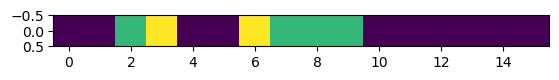

In [40]:
# 轉換成1x16的圖像
image_size = len(personality_mapping)

# 创建一个空的列表来存储图像数据
image_data = []

for personality_num in X_train:
    image_data.append(np.array(personality_num).reshape(1, 16))

# 顯示圖像
plt.imshow(image_data[0], cmap='viridis')  # 使用'viridis'色彩地圖，你可以根據需要更改色彩地圖

image_data_val = []
for personality_num in X_val:
    image_data_val.append(np.array(personality_num).reshape(1, 16))

In [41]:
print(image_data[0])

# 将列表 image_data 转换为 PyTorch 张量
image_data_tensor = torch.tensor(image_data)

image_data_val_tensor = torch.tensor(image_data_val)

[[0.   0.   0.14 0.21 0.   0.   0.21 0.14 0.14 0.14 0.   0.   0.   0.
  0.   0.  ]]


C:\Users\JenMing\AppData\Local\Temp\ipykernel_22868\3342659498.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  image_data_tensor = torch.tensor(image_data)


In [42]:
# 创建数据加载器
train_data = TensorDataset(image_data_tensor, train_target)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_data = TensorDataset(image_data_val_tensor, val_target)
val_loader = DataLoader(val_data, batch_size=64)

In [43]:
# 构建CNN模型
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*6*6, 128)
        self.fc2 = nn.Linear(128, 16)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32*6*6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [44]:
model = CNNModel()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 30

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # 在验证集上评估模型
    with torch.no_grad():
        val_loss = 0.0
        val_correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(val_loader):
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {(100 * val_correct / total):.2f}%')

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[1, 64, 1, 16] to have 1 channels, but got 64 channels instead

In [ ]:
# 在测试集上评估模型
with torch.no_grad():
    test_correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(test_loader):
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {(100 * test_correct / total):.2f}%')